In [648]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision import datasets
import torchvision.transforms as transforms

In [649]:
# 데이터 전처리
data_transform = transforms.Compose([
    transforms.ToTensor(),
    # 이미지의 크기를 32로 맞춰준다.
    transforms.Resize(32),
    transforms.Normalize((0.5,),(1.0))
])


train_data = datasets.MNIST(root='./', train = True, download = True, transform = data_transform)
test_data = datasets.MNIST(root = './', train = False, download = True, transform = data_transform)


In [650]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 32)

# 모델

In [651]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.tanh(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.conv2(x)
        x = F.tanh(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.conv3(x)
        x = F.tanh(x)
        # 평평하게 펴기
        x = x.view(-1, 120)
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        x = F.tanh(x)
        return x

model = Net()
print(model)


Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


In [652]:
image = torch.randn((1,1,32,32))
model(image)

tensor([[ 0.0211,  0.0247, -0.0201, -0.0277, -0.0073, -0.0370,  0.1276,  0.0633,
         -0.1223,  0.0428]], grad_fn=<TanhBackward>)

In [653]:
x_train, y_train = train_data.data, train_data.targets
x_test,y_test = test_data.data, test_data.targets

x_train.shape

torch.Size([60000, 28, 28])

In [654]:
x_train = x_train.unsqueeze(1)
x_train.shape

torch.Size([60000, 1, 28, 28])

In [655]:
x_test = x_test.unsqueeze(1)
x_test.shape

torch.Size([10000, 1, 28, 28])

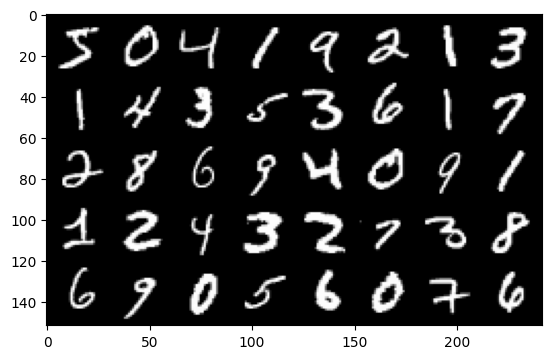

In [656]:
import matplotlib.pyplot as plt
from torchvision import utils
def show(img):
    temp_img = img.numpy()
    temp_img_tr = temp_img.transpose((1,2,0))
    plt.imshow(temp_img_tr,cmap='gray')

# 여러개의 이미지 한눈에 보고 싶을 때
image_grid = utils.make_grid(x_train[:40], nrow=8, padding = 2)
show(image_grid)

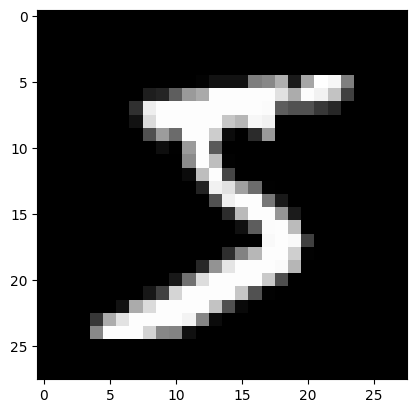

In [657]:
import matplotlib.pyplot as plt

def show(img):
    temp_img = img.numpy()
    temp_img_tr = temp_img.transpose((1, 2, 0))
    plt.imshow(temp_img_tr, cmap='gray')
    plt.show()

show(x_train[0])


In [658]:
data,label = next(iter(train_loader))
print(data.shape)
print(label.shape)

torch.Size([32, 1, 32, 32])
torch.Size([32])


In [659]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

from torchsummary import summary
# input 사이즈는 배치 빼고 들어간다. torch는 앞에가 채널값이야.
summary(model, input_size = (1, 32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Conv2d-3            [-1, 120, 1, 1]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


## 학습

In [660]:
optim = Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    for data, label in train_loader:
        optim.zero_grad()
        pred = model(data.to(device))
        loss = nn.CrossEntropyLoss()(pred, label.to(device))
        loss.backward()
        optim.step()
        
    print(f'{epoch+1} loss : {loss.item()}')

1 loss : 0.8756493926048279
2 loss : 0.8505761027336121
3 loss : 0.8013972640037537
4 loss : 0.819171667098999
5 loss : 0.7998875379562378
6 loss : 0.7967509627342224
7 loss : 0.8071784973144531
8 loss : 0.7968776226043701
9 loss : 0.8540741205215454
10 loss : 0.7973096370697021


In [662]:
optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

### 검증

In [684]:
model.eval()

with torch.no_grad():
    total_corr = 0
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        preds = model(images)
        
        # 각각 저장이 된다. 이렇게 하면
        _, pred = torch.max(preds.data, 1)
        total_corr += (pred == labels).sum().item()
    
    print(f'Acc {total_corr / len(test_data.targets)}')

Acc 0.9862


In [685]:
model

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

In [374]:
test_data.data[500].size()

torch.Size([28, 28])

#### unsqueeze(index) : 해당 index에 차원 추가
#### squeeze(index) : 해당 index에 차원 삭제


In [430]:
img = test_data.data[500].unsqueeze(dim = 0)
img.size()

torch.Size([1, 28, 28])

In [431]:
x_train[0].size()

torch.Size([1, 28, 28])

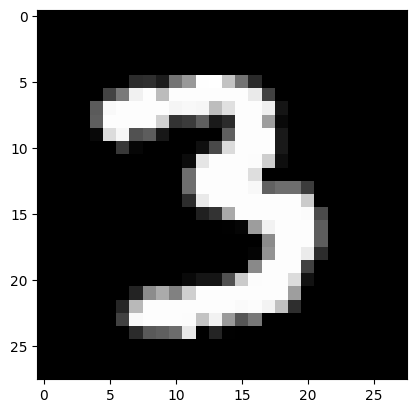

In [432]:
show(test_data.data[500].unsqueeze(0))
# 차원을 맞춰줘야한다, 

### 모델에도 적용해보기 

In [686]:
img = test_data.data[500].unsqueeze(dim = 0)
img.size()

torch.Size([1, 28, 28])

In [687]:
test_data.data[500].unsqueeze(dim = 0).size()

torch.Size([1, 28, 28])

In [688]:
img.size()

torch.Size([1, 28, 28])

In [689]:
model

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

In [690]:
img = test_data.data[500].unsqueeze(dim = 0)
img1 = img.unsqueeze(dim = 1)
img1.size()

torch.Size([1, 1, 28, 28])

In [691]:
from PIL import Image
# 데이터 전처리
test_data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(32),
    transforms.Normalize((0.5,),(1.0))
])


img2 = test_data_transform(pil_img)
img2.size()

torch.Size([1, 32, 32])

In [692]:
for i, j in test_loader:
    print(i)

tensor([[[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          ...,
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]]],


        [[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          ...,
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]]],


        [[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.500

tensor([[[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          ...,
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]]],


        [[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          ...,
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]]],


        [[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.500

tensor([[[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          ...,
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]]],


        [[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          ...,
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]]],


        [[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.500

tensor([[[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          ...,
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]]],


        [[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          ...,
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]]],


        [[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.500

tensor([[[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          ...,
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]]],


        [[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          ...,
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]]],


        [[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.500

tensor([[[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          ...,
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]]],


        [[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          ...,
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]]],


        [[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.500

tensor([[[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          ...,
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]]],


        [[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          ...,
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]]],


        [[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.500

In [693]:
r_img

tensor([[[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          ...,
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]]]])

In [694]:
r_img = img2.unsqueeze(dim = 1)
r_img.size()

torch.Size([1, 1, 32, 32])

In [695]:
pred = model(r_img.to(device))
pred

tensor([[-1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000]], device='cuda:0', grad_fn=<TanhBackward>)

In [697]:
with torch.no_grad():
    output1 = model(r_img.to(device))

predicted_class1 = output1.argmax(dim=1).item()

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
predicted_label1 = class_names[predicted_class1]

print(f"Predicted label: {predicted_label1}")

Predicted label: 3


### 강사님 숫자 추론

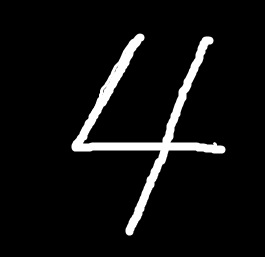

In [698]:
from PIL import Image
import numpy as np
path = './test_img.jpg'

img_t = Image.open(path)

img_t

In [699]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    # 이미지의 크기를 32로 맞춰준다.
    transforms.Resize(32),
    transforms.Normalize((0.5,),(1.0))
])


im_transformed  = data_transform(img_t)
im_transformed 

tensor([[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
         [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
         [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
         ...,
         [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
         [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
         [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]],

        [[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
         [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
         [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
         ...,
         [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
         [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
         [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]],

        [[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
         [-0.5000, -0.5000, -0.5000,  ..., -0

In [700]:
gray_im1 = torch.mean(im_transformed, dim=0, keepdim=True)
gray_im1

tensor([[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
         [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
         [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
         ...,
         [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
         [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
         [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]]])

In [701]:
gray_im = gray_im1.unsqueeze(dim = 1)
gray_im.size()

torch.Size([1, 1, 32, 32])

In [702]:
gray_im

tensor([[[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          ...,
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]]]])

In [703]:
model_t = model(gray_im.to(device))
model_t

tensor([[-1.0000, -1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000]], device='cuda:0', grad_fn=<TanhBackward>)

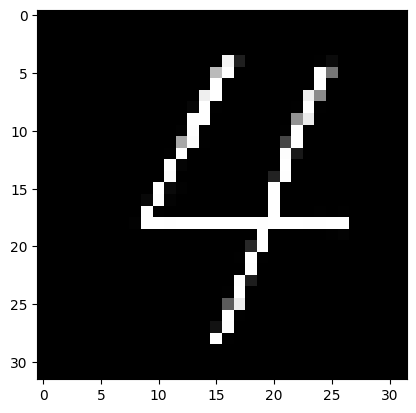

In [704]:
show(gray_im1)

In [705]:
with torch.no_grad():
    output = model(gray_im.to(device))

predicted_class = output.argmax(dim=1).item()

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
predicted_label = class_names[predicted_class]

print(f"Predicted label: {predicted_label}")

Predicted label: 4
